In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import glob
import random
import rasterio
import numpy as np
import classic_algos.bicubic_interpolation as bicubic
import classic_algos.lanczos as lanczos
from skimage.color import rgb2ycbcr

import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from pathlib import Path

# Настройки воспроизводимости и ускорения как в статье
import torch.backends.cudnn as cudnn

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


class SatelliteSRDataset(Dataset):
    def __init__(self, root_dir, scale_factor=3, hr_patch_size=144, augment=True):
        super().__init__()
        self.root_dir = root_dir
        self.scale_factor = scale_factor
        self.hr_patch_size = hr_patch_size
        self.augment = augment

        self.file_paths = glob.glob(os.path.join(root_dir, '**', '*.tif'), recursive=True)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        with rasterio.open(img_path) as src:
            image = src.read()  # C x H x W

        image_norm = image.astype(np.float32) / 255.0

        #random crop
        c, h, w = image_norm.shape
        top = random.randint(0, h - self.hr_patch_size)
        left = random.randint(0, w - self.hr_patch_size)
        hr_patch_np = image_norm[:, top:top + self.hr_patch_size, left:left + self.hr_patch_size]
        if self.augment:
            # Flip Horizontal
            if random.random() < 0.5:
                hr_patch_np = np.flip(hr_patch_np, axis=2)

            # Flip Vertical
            if random.random() < 0.5:
                hr_patch_np = np.flip(hr_patch_np, axis=1)

            # rotations
            k = random.choice([0, 1, 2, 3])
            if k > 0:
                hr_patch_np = np.rot90(hr_patch_np, k, axes=(1, 2))

        hr_patch_np = np.ascontiguousarray(hr_patch_np.astype(np.float32))  # C x H x W, [0,1]
        hr_tensor = torch.from_numpy(hr_patch_np).float()

        # LR from augmented HR patch
        hr_patch_hwc = np.transpose(hr_patch_np, (1, 2, 0))  # H x W x C, [0,1]
        lr_size = self.hr_patch_size // self.scale_factor
        lr_numpy_hwc = bicubic.SR_bicubic(hr_patch_hwc, lr_size, lr_size, preserve_range=True, output_dtype=np.float32)
        lr_numpy = np.transpose(lr_numpy_hwc, (2, 0, 1))  # C x h_lr x w_lr
        lr_tensor = torch.from_numpy(lr_numpy.astype(np.float32))

        return lr_tensor, hr_tensor


'train'


def PSNR(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10 * torch.log10(1 / (mse + 1e-20))


BATCH_SIZE = 16
EPOCHS = 2000

TRAIN_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'train'
VAL_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'val'
MODEL_DIR = Path.home() / '.data' / 'fsrcnn_models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)

## Вариант 2: Обучение на Y-канале (Яркость)
'''
Ниже
будет
реализован
второй, независимый
пайплайн, который
работает
только
с
каналом
яркости(Y)
из
цветового
пространства
YCbCr.
'''

class SatelliteSRDataset_Y(Dataset):
    def __init__(self, root_dir, scale_factor=2, hr_patch_size=20, augment=True):
        super().__init__()
        self.root_dir = root_dir
        self.scale_factor = scale_factor
        self.hr_patch_size = hr_patch_size
        self.augment = augment
        self.file_paths = glob.glob(os.path.join(root_dir, '**', '*.tif'), recursive=True)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        with rasterio.open(img_path) as src:
            image = src.read()

        image_hwc = np.transpose(image, (1, 2, 0)).astype(np.uint8)

        image_y = rgb2ycbcr(image_hwc)[:, :, 0]

        image_norm = image_y.astype(np.float32) / 255.0

        image_norm = image_norm[np.newaxis, :, :]

        c, h, w = image_norm.shape
        top = random.randint(0, h - self.hr_patch_size)
        left = random.randint(0, w - self.hr_patch_size)
        hr_patch_np = image_norm[:, top:top + self.hr_patch_size, left:left + self.hr_patch_size]

        if self.augment:
            if random.random() < 0.5: hr_patch_np = np.flip(hr_patch_np, axis=2)
            if random.random() < 0.5: hr_patch_np = np.flip(hr_patch_np, axis=1)
            k = random.choice([0, 1, 2, 3])
            if k > 0: hr_patch_np = np.rot90(hr_patch_np, k, axes=(1, 2))

        hr_patch_np = np.ascontiguousarray(hr_patch_np)
        hr_tensor = torch.from_numpy(hr_patch_np).float()

        hr_patch_hwc = np.transpose(hr_patch_np, (1, 2, 0))
        lr_size = self.hr_patch_size // self.scale_factor
        lr_numpy_hwc = bicubic.SR_bicubic(hr_patch_hwc, lr_size, lr_size, preserve_range=True, output_dtype=np.float32)

        if lr_numpy_hwc.ndim == 2:
            lr_numpy_hwc = lr_numpy_hwc[:, :, np.newaxis]

        lr_numpy = np.transpose(lr_numpy_hwc, (2, 0, 1))
        lr_tensor = torch.from_numpy(lr_numpy.astype(np.float32))

        return lr_tensor, hr_tensor


import torch
import torch.nn as nn


# === 1. Блок Внимания (Channel Attention) ===
class ChannelAttention(nn.Module):
    def __init__(self, num_features, reduction=16):
        super(ChannelAttention, self).__init__()
        # Global Average Pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # MLP (сжатие -> расширение)
        self.fc = nn.Sequential(
            nn.Conv2d(num_features, num_features // reduction, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_features // reduction, num_features, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.fc(y)
        return x * y  # Умножаем вход на "важность" каналов


# === 2. Блок RCAB (вместо ResidualBlock) ===
class RCAB(nn.Module):
    def __init__(self, channels, reduction=16):
        super(RCAB, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            ChannelAttention(channels, reduction)
        )

    def forward(self, x):
        res = self.body(x)
        return res + x  # Skip connection


# === 3. Основная модель (RCAN-lite) ===
class FSRCNN_Y(nn.Module):
    def __init__(self, scale_factor=2, num_channels=1, num_res_blocks=16, n_feats=64):
        """
        num_res_blocks: увеличено до 16 (было 8). Если есть память, можно 20+.
        n_feats: количество фильтров (64 стандарт, можно 96 или 128).
        """
        super(FSRCNN_Y, self).__init__()

        # 1. Head
        self.head = nn.Conv2d(num_channels, n_feats, kernel_size=3, padding=1)

        # 2. Body (много блоков RCAB)
        self.body = nn.Sequential(*[
            RCAB(n_feats) for _ in range(num_res_blocks)
        ])

        self.body_end = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)

        # 3. Upsampling
        if scale_factor == 2:
            self.upsample = nn.Sequential(
                nn.Conv2d(n_feats, n_feats * 4, kernel_size=3, padding=1),
                nn.PixelShuffle(2),
                # Убрали ReLU в конце апсемплинга для более точного восстановления диапазона
            )
        elif scale_factor == 3:
            self.upsample = nn.Sequential(
                nn.Conv2d(n_feats, n_feats * 9, kernel_size=3, padding=1),
                nn.PixelShuffle(3),
            )
        elif scale_factor == 4:
            self.upsample = nn.Sequential(
                nn.Conv2d(n_feats, n_feats * 4, kernel_size=3, padding=1),
                nn.PixelShuffle(2),
                nn.ReLU(inplace=True),  # Здесь ReLU можно оставить между блоками
                nn.Conv2d(n_feats, n_feats * 4, kernel_size=3, padding=1),
                nn.PixelShuffle(2),
            )

        # 4. Tail
        self.tail = nn.Conv2d(n_feats, num_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x_head = self.head(x)

        res = self.body(x_head)
        res = self.body_end(res)
        res += x_head  # Global Residual Learning

        x_up = self.upsample(res)
        out = self.tail(x_up)

        return torch.clamp(out, 0.0, 1.0)


# === 4. Функция потерь Charbonnier ===
class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        diff = x - y
        loss = torch.mean(torch.sqrt(diff * diff + self.eps * self.eps))
        return loss


y_train_dataset = SatelliteSRDataset_Y(TRAIN_DIR, scale_factor=2, hr_patch_size=144, augment=True)
y_val_dataset = SatelliteSRDataset_Y(VAL_DIR, scale_factor=2, hr_patch_size=144, augment=False)
y_train_loader = DataLoader(y_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
y_val_loader = DataLoader(y_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Модель потяжелее: 16 блоков, 64 канала
y_model = FSRCNN_Y(scale_factor=2, num_res_blocks=16, n_feats=64).to(device)

# Новый Лосс
y_criterion = CharbonnierLoss()

# Оптимизатор тот же (Adam)
y_optimizer = optim.Adam(y_model.parameters(), lr=1e-4, betas=(0.9, 0.999))
y_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(y_optimizer, mode='min', factor=0.5, patience=10)

y_loss = []
y_psnr_metric = []
best_psnr = 0

cuda


In [ ]:
for epoch in range(EPOCHS):
    y_model.train()
    epoch_loss = 0
    for lr_imgs, hr_imgs in tqdm(y_train_loader, desc=f"Epoch {epoch} (Y)"):
        lr_imgs, hr_imgs = lr_imgs.to(device, non_blocking=True), hr_imgs.to(device, non_blocking=True)
        y_optimizer.zero_grad()
        sr_imgs = y_model(lr_imgs)
        batch_loss = y_criterion(sr_imgs, hr_imgs)
        batch_loss.backward()
        y_optimizer.step()
        epoch_loss += batch_loss.item()

    avg_loss = epoch_loss / len(y_train_loader)
    y_loss.append(avg_loss)
    # === VALIDATION (Каждую эпоху!) ===
    y_model.eval()
    val_loss = 0
    val_psnr = 0
    with torch.no_grad():
        for lr_imgs, hr_imgs in y_val_loader:  # убираем tqdm тут, чтобы не засорять лог
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = y_model(lr_imgs)

            # Считаем и Loss, и PSNR
            loss = y_criterion(sr_imgs, hr_imgs)
            val_loss += loss.item()
            val_psnr += PSNR(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(y_val_loader)
    avg_val_psnr = val_psnr / len(y_val_loader)

    print(f"Epoch {epoch}: Train Loss: {avg_loss:.5f} | Val Loss: {avg_val_loss:.5f} | Val PSNR: {avg_val_psnr:.2f} dB")

    # === SCHEDULER STEP ===
    # Скармливаем ему Валидационный Лосс
    y_scheduler.step(avg_val_loss)

    # Сохраняем лучшую модель
    if avg_val_psnr > best_psnr:
        best_psnr = avg_val_psnr
        torch.save(y_model.state_dict(), MODEL_DIR / 'cooler_best_model.pth')
        print(f"  [!] New Best PSNR: {best_psnr:.2f} dB saved.")

    # Можно сохранять чекпоинт раз в N эпох на всякий случай
    if epoch % 20 == 0:
        torch.save(y_model.state_dict(), MODEL_DIR / f'cooler_checkpoint_{epoch}.pth')

print("Y-channel training complete.")

Epoch 0 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 0: Train Loss: 0.02282 | Val Loss: 0.02061 | Val PSNR: 28.56 dB
  [!] New Best PSNR: 28.56 dB saved.


Epoch 1 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 1: Train Loss: 0.01961 | Val Loss: 0.01867 | Val PSNR: 28.86 dB
  [!] New Best PSNR: 28.86 dB saved.


Epoch 2 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 2: Train Loss: 0.01919 | Val Loss: 0.01945 | Val PSNR: 28.86 dB
  [!] New Best PSNR: 28.86 dB saved.


Epoch 3 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 3: Train Loss: 0.01856 | Val Loss: 0.01822 | Val PSNR: 29.01 dB
  [!] New Best PSNR: 29.01 dB saved.


Epoch 4 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 4: Train Loss: 0.01816 | Val Loss: 0.01944 | Val PSNR: 28.97 dB


Epoch 5 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 5: Train Loss: 0.01818 | Val Loss: 0.01950 | Val PSNR: 29.00 dB


Epoch 6 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 6: Train Loss: 0.01795 | Val Loss: 0.01869 | Val PSNR: 29.17 dB
  [!] New Best PSNR: 29.17 dB saved.


Epoch 7 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 7: Train Loss: 0.01760 | Val Loss: 0.01802 | Val PSNR: 29.22 dB
  [!] New Best PSNR: 29.22 dB saved.


Epoch 8 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 8: Train Loss: 0.01742 | Val Loss: 0.01775 | Val PSNR: 29.34 dB
  [!] New Best PSNR: 29.34 dB saved.


Epoch 9 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 9: Train Loss: 0.01775 | Val Loss: 0.01925 | Val PSNR: 29.21 dB


Epoch 10 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 10: Train Loss: 0.01758 | Val Loss: 0.01815 | Val PSNR: 29.23 dB


Epoch 11 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 11: Train Loss: 0.01722 | Val Loss: 0.01747 | Val PSNR: 29.45 dB
  [!] New Best PSNR: 29.45 dB saved.


Epoch 12 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 12: Train Loss: 0.01658 | Val Loss: 0.01811 | Val PSNR: 29.26 dB


Epoch 13 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 13: Train Loss: 0.01695 | Val Loss: 0.01787 | Val PSNR: 29.48 dB
  [!] New Best PSNR: 29.48 dB saved.


Epoch 14 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 14: Train Loss: 0.01673 | Val Loss: 0.01761 | Val PSNR: 29.42 dB


Epoch 15 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 15: Train Loss: 0.01663 | Val Loss: 0.01753 | Val PSNR: 29.42 dB


Epoch 16 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 16: Train Loss: 0.01618 | Val Loss: 0.01645 | Val PSNR: 29.53 dB
  [!] New Best PSNR: 29.53 dB saved.


Epoch 17 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 17: Train Loss: 0.01588 | Val Loss: 0.01663 | Val PSNR: 29.53 dB
  [!] New Best PSNR: 29.53 dB saved.


Epoch 18 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 18: Train Loss: 0.01634 | Val Loss: 0.01654 | Val PSNR: 29.56 dB
  [!] New Best PSNR: 29.56 dB saved.


Epoch 19 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 19: Train Loss: 0.01627 | Val Loss: 0.01637 | Val PSNR: 29.57 dB
  [!] New Best PSNR: 29.57 dB saved.


Epoch 20 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 20: Train Loss: 0.01644 | Val Loss: 0.01731 | Val PSNR: 29.65 dB
  [!] New Best PSNR: 29.65 dB saved.


Epoch 21 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 21: Train Loss: 0.01681 | Val Loss: 0.01752 | Val PSNR: 29.53 dB


Epoch 22 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 22: Train Loss: 0.01604 | Val Loss: 0.01684 | Val PSNR: 29.61 dB


Epoch 23 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 23: Train Loss: 0.01609 | Val Loss: 0.01694 | Val PSNR: 29.68 dB
  [!] New Best PSNR: 29.68 dB saved.


Epoch 24 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 24: Train Loss: 0.01625 | Val Loss: 0.01749 | Val PSNR: 29.65 dB


Epoch 25 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 25: Train Loss: 0.01597 | Val Loss: 0.01674 | Val PSNR: 29.58 dB


Epoch 26 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 26: Train Loss: 0.01614 | Val Loss: 0.01624 | Val PSNR: 29.68 dB


Epoch 27 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 27: Train Loss: 0.01613 | Val Loss: 0.01663 | Val PSNR: 29.69 dB
  [!] New Best PSNR: 29.69 dB saved.


Epoch 28 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 28: Train Loss: 0.01593 | Val Loss: 0.01642 | Val PSNR: 29.70 dB
  [!] New Best PSNR: 29.70 dB saved.


Epoch 29 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 29: Train Loss: 0.01597 | Val Loss: 0.01620 | Val PSNR: 29.68 dB


Epoch 30 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 30: Train Loss: 0.01558 | Val Loss: 0.01606 | Val PSNR: 29.68 dB


Epoch 31 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 31: Train Loss: 0.01604 | Val Loss: 0.01663 | Val PSNR: 29.71 dB
  [!] New Best PSNR: 29.71 dB saved.


Epoch 32 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 32: Train Loss: 0.01615 | Val Loss: 0.01607 | Val PSNR: 29.74 dB
  [!] New Best PSNR: 29.74 dB saved.


Epoch 33 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 33: Train Loss: 0.01595 | Val Loss: 0.01667 | Val PSNR: 29.72 dB


Epoch 34 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 34: Train Loss: 0.01603 | Val Loss: 0.01641 | Val PSNR: 29.75 dB
  [!] New Best PSNR: 29.75 dB saved.


Epoch 35 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 35: Train Loss: 0.01589 | Val Loss: 0.01660 | Val PSNR: 29.72 dB


Epoch 36 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 36: Train Loss: 0.01594 | Val Loss: 0.01665 | Val PSNR: 29.78 dB
  [!] New Best PSNR: 29.78 dB saved.


Epoch 37 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 37: Train Loss: 0.01635 | Val Loss: 0.01602 | Val PSNR: 29.82 dB
  [!] New Best PSNR: 29.82 dB saved.


Epoch 38 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 38: Train Loss: 0.01583 | Val Loss: 0.01719 | Val PSNR: 29.61 dB


Epoch 39 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 39: Train Loss: 0.01561 | Val Loss: 0.01573 | Val PSNR: 29.83 dB
  [!] New Best PSNR: 29.83 dB saved.


Epoch 40 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 40: Train Loss: 0.01556 | Val Loss: 0.01682 | Val PSNR: 29.79 dB


Epoch 41 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 41: Train Loss: 0.01583 | Val Loss: 0.01657 | Val PSNR: 29.69 dB


Epoch 42 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 42: Train Loss: 0.01582 | Val Loss: 0.01677 | Val PSNR: 29.70 dB


Epoch 43 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 43: Train Loss: 0.01580 | Val Loss: 0.01665 | Val PSNR: 29.71 dB


Epoch 44 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 44: Train Loss: 0.01571 | Val Loss: 0.01594 | Val PSNR: 29.72 dB


Epoch 45 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 45: Train Loss: 0.01536 | Val Loss: 0.01613 | Val PSNR: 29.77 dB


Epoch 46 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 46: Train Loss: 0.01549 | Val Loss: 0.01649 | Val PSNR: 29.81 dB


Epoch 47 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 47: Train Loss: 0.01575 | Val Loss: 0.01612 | Val PSNR: 29.78 dB


Epoch 48 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 48: Train Loss: 0.01540 | Val Loss: 0.01648 | Val PSNR: 29.77 dB


Epoch 49 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 49: Train Loss: 0.01584 | Val Loss: 0.01674 | Val PSNR: 29.74 dB


Epoch 50 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 50: Train Loss: 0.01562 | Val Loss: 0.01633 | Val PSNR: 29.81 dB


Epoch 51 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 51: Train Loss: 0.01504 | Val Loss: 0.01574 | Val PSNR: 29.76 dB


Epoch 52 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 52: Train Loss: 0.01494 | Val Loss: 0.01543 | Val PSNR: 29.96 dB
  [!] New Best PSNR: 29.96 dB saved.


Epoch 53 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 53: Train Loss: 0.01499 | Val Loss: 0.01573 | Val PSNR: 29.80 dB


Epoch 54 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 54: Train Loss: 0.01495 | Val Loss: 0.01575 | Val PSNR: 29.81 dB


Epoch 55 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 55: Train Loss: 0.01499 | Val Loss: 0.01565 | Val PSNR: 29.77 dB


Epoch 56 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 56: Train Loss: 0.01492 | Val Loss: 0.01565 | Val PSNR: 29.80 dB


Epoch 57 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 57: Train Loss: 0.01497 | Val Loss: 0.01554 | Val PSNR: 29.90 dB


Epoch 58 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 58: Train Loss: 0.01501 | Val Loss: 0.01560 | Val PSNR: 29.83 dB


Epoch 59 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 59: Train Loss: 0.01494 | Val Loss: 0.01560 | Val PSNR: 29.87 dB


Epoch 60 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 60: Train Loss: 0.01507 | Val Loss: 0.01599 | Val PSNR: 29.86 dB


Epoch 61 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 61: Train Loss: 0.01519 | Val Loss: 0.01559 | Val PSNR: 30.00 dB
  [!] New Best PSNR: 30.00 dB saved.


Epoch 62 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 62: Train Loss: 0.01506 | Val Loss: 0.01564 | Val PSNR: 29.82 dB


Epoch 63 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 63: Train Loss: 0.01486 | Val Loss: 0.01561 | Val PSNR: 29.83 dB


Epoch 64 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 64: Train Loss: 0.01491 | Val Loss: 0.01552 | Val PSNR: 29.82 dB


Epoch 65 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 65: Train Loss: 0.01489 | Val Loss: 0.01549 | Val PSNR: 29.87 dB


Epoch 66 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 66: Train Loss: 0.01484 | Val Loss: 0.01541 | Val PSNR: 29.95 dB


Epoch 67 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 67: Train Loss: 0.01482 | Val Loss: 0.01542 | Val PSNR: 29.97 dB


Epoch 68 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 68: Train Loss: 0.01486 | Val Loss: 0.01556 | Val PSNR: 29.81 dB


Epoch 69 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 69: Train Loss: 0.01483 | Val Loss: 0.01532 | Val PSNR: 29.99 dB


Epoch 70 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 70: Train Loss: 0.01490 | Val Loss: 0.01558 | Val PSNR: 29.87 dB


Epoch 71 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 71: Train Loss: 0.01487 | Val Loss: 0.01538 | Val PSNR: 29.93 dB


Epoch 72 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 72: Train Loss: 0.01485 | Val Loss: 0.01557 | Val PSNR: 29.88 dB


Epoch 73 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 73: Train Loss: 0.01483 | Val Loss: 0.01562 | Val PSNR: 29.83 dB


Epoch 74 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 74: Train Loss: 0.01488 | Val Loss: 0.01555 | Val PSNR: 29.85 dB


Epoch 75 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 75: Train Loss: 0.01487 | Val Loss: 0.01556 | Val PSNR: 29.87 dB


Epoch 76 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 76: Train Loss: 0.01480 | Val Loss: 0.01545 | Val PSNR: 29.89 dB


Epoch 77 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 77: Train Loss: 0.01483 | Val Loss: 0.01530 | Val PSNR: 29.96 dB


Epoch 78 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 78: Train Loss: 0.01485 | Val Loss: 0.01543 | Val PSNR: 29.93 dB


Epoch 79 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 79: Train Loss: 0.01480 | Val Loss: 0.01536 | Val PSNR: 29.95 dB


Epoch 80 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 80: Train Loss: 0.01496 | Val Loss: 0.01562 | Val PSNR: 29.87 dB


Epoch 81 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 81: Train Loss: 0.01476 | Val Loss: 0.01549 | Val PSNR: 29.87 dB


Epoch 82 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 82: Train Loss: 0.01477 | Val Loss: 0.01553 | Val PSNR: 29.84 dB


Epoch 83 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 83: Train Loss: 0.01483 | Val Loss: 0.01533 | Val PSNR: 30.00 dB
  [!] New Best PSNR: 30.00 dB saved.


Epoch 84 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 84: Train Loss: 0.01486 | Val Loss: 0.01558 | Val PSNR: 29.88 dB


Epoch 85 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 85: Train Loss: 0.01484 | Val Loss: 0.01556 | Val PSNR: 29.86 dB


Epoch 86 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 86: Train Loss: 0.01483 | Val Loss: 0.01542 | Val PSNR: 29.93 dB


Epoch 87 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 87: Train Loss: 0.01484 | Val Loss: 0.01556 | Val PSNR: 29.91 dB


Epoch 88 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 88: Train Loss: 0.01476 | Val Loss: 0.01542 | Val PSNR: 29.98 dB


Epoch 89 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 89: Train Loss: 0.01475 | Val Loss: 0.01546 | Val PSNR: 29.91 dB


Epoch 90 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 90: Train Loss: 0.01470 | Val Loss: 0.01561 | Val PSNR: 29.80 dB


Epoch 91 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 91: Train Loss: 0.01478 | Val Loss: 0.01559 | Val PSNR: 29.86 dB


Epoch 92 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 92: Train Loss: 0.01476 | Val Loss: 0.01532 | Val PSNR: 29.97 dB


Epoch 93 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 93: Train Loss: 0.01485 | Val Loss: 0.01543 | Val PSNR: 29.94 dB


Epoch 94 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 94: Train Loss: 0.01473 | Val Loss: 0.01546 | Val PSNR: 29.89 dB


Epoch 95 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 95: Train Loss: 0.01480 | Val Loss: 0.01547 | Val PSNR: 29.94 dB


Epoch 96 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 96: Train Loss: 0.01479 | Val Loss: 0.01536 | Val PSNR: 29.95 dB


Epoch 97 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 97: Train Loss: 0.01475 | Val Loss: 0.01527 | Val PSNR: 29.97 dB


Epoch 98 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 98: Train Loss: 0.01481 | Val Loss: 0.01533 | Val PSNR: 29.97 dB


Epoch 99 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 99: Train Loss: 0.01478 | Val Loss: 0.01560 | Val PSNR: 29.85 dB


Epoch 100 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 100: Train Loss: 0.01478 | Val Loss: 0.01544 | Val PSNR: 29.94 dB


Epoch 101 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 101: Train Loss: 0.01476 | Val Loss: 0.01559 | Val PSNR: 29.81 dB


Epoch 102 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 102: Train Loss: 0.01477 | Val Loss: 0.01553 | Val PSNR: 29.86 dB


Epoch 103 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 103: Train Loss: 0.01473 | Val Loss: 0.01541 | Val PSNR: 29.95 dB


Epoch 104 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 104: Train Loss: 0.01476 | Val Loss: 0.01542 | Val PSNR: 29.91 dB


Epoch 105 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 105: Train Loss: 0.01477 | Val Loss: 0.01528 | Val PSNR: 29.96 dB


Epoch 106 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 106: Train Loss: 0.01481 | Val Loss: 0.01545 | Val PSNR: 29.89 dB


Epoch 107 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 107: Train Loss: 0.01466 | Val Loss: 0.01524 | Val PSNR: 29.99 dB


Epoch 108 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

/home/aaa/.data/fsrcnn_models/cooler_best_model.pth


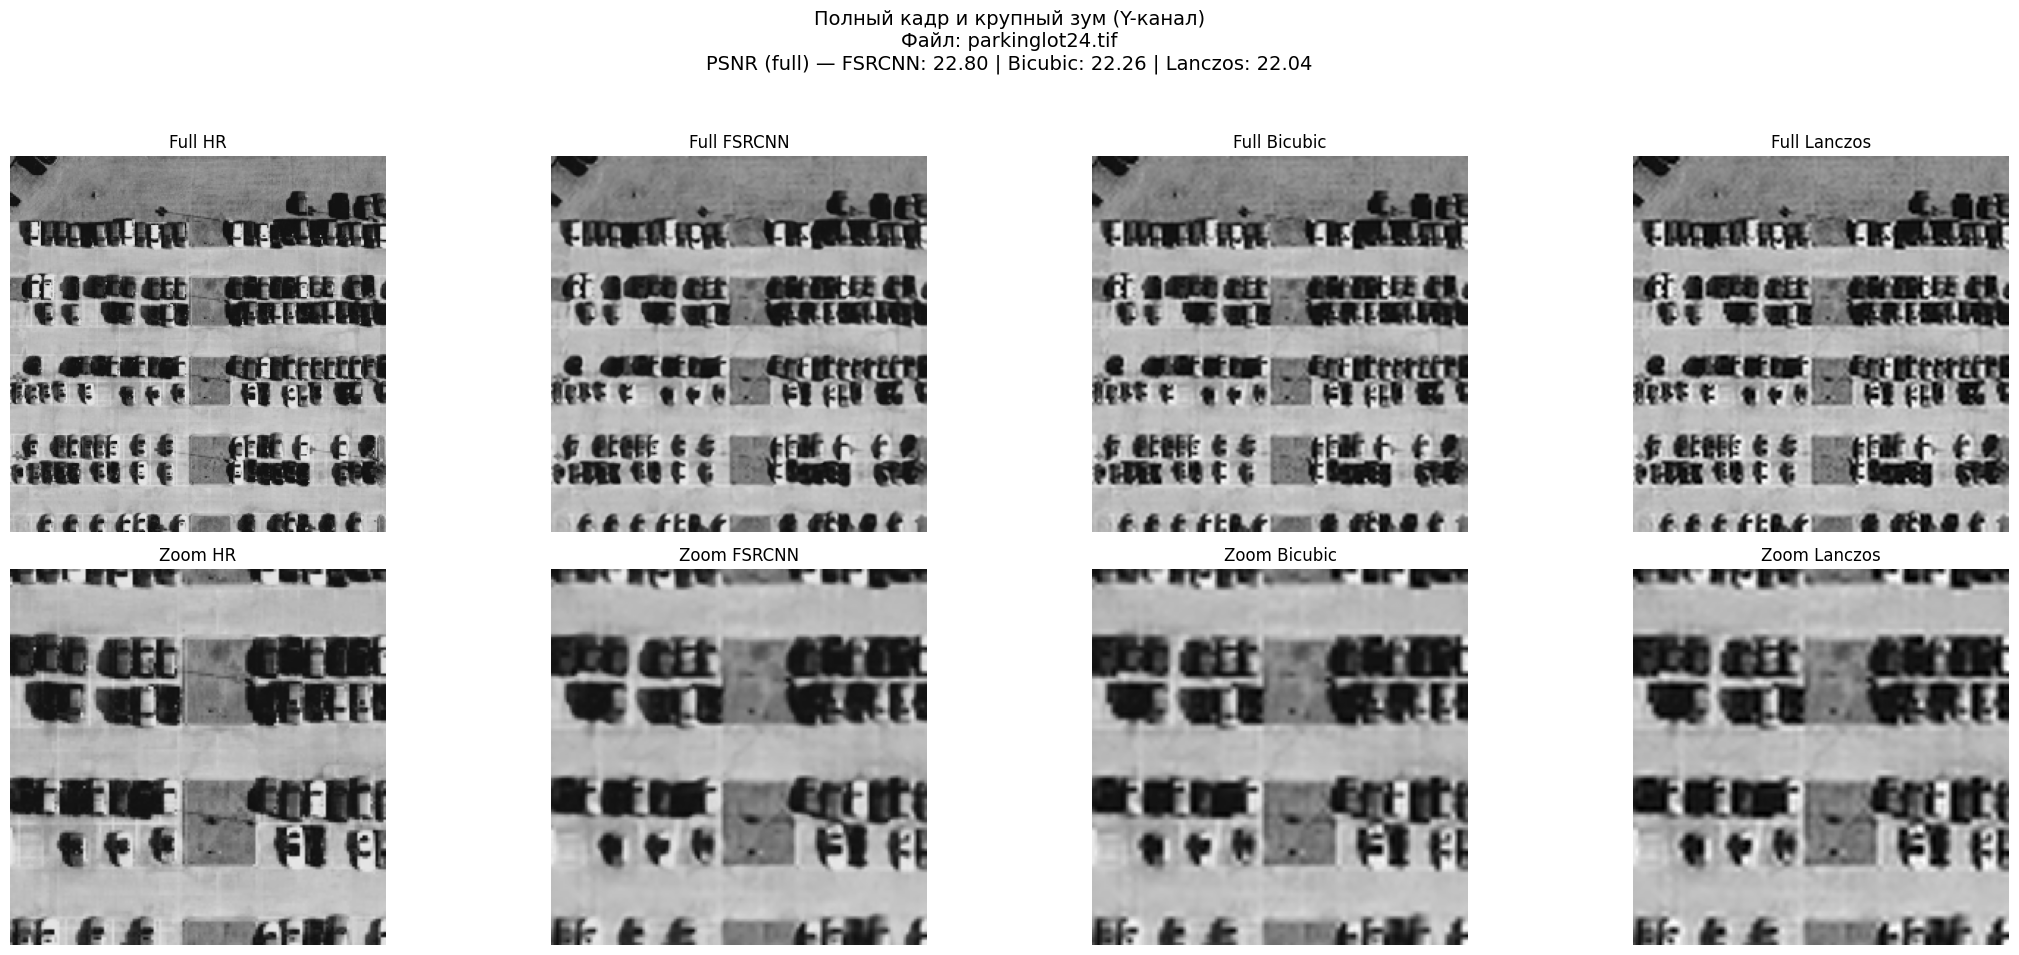

Full-image PSNR — FSRCNN: 22.80 dB | Bicubic: 22.26 dB | Lanczos: 22.04 dB
Zoom region: top=56, left=56, size=144x144


In [4]:
# Настройки визуализации
ZOOM_PATCH_SIZE = 144  # размер квадрата для зума на HR масштабе
ZOOM_TOP_LEFT = None   # (top, left) если None, выберется центр кадра
SCALE_Y = 2            # масштаб для Y-модели

# 1) Выбор исходного файла из валид. набора и загрузка полного изображения
full_idx = random.randint(0, len(y_val_dataset.file_paths) - 1)
img_path = y_val_dataset.file_paths[full_idx]
with rasterio.open(img_path) as src:
    image = src.read()  # C x H x W, ожидаем RGB

# Перевод в HWC и Y-канал
image_hwc = np.transpose(image, (1, 2, 0)).astype(np.uint8)
image_y = rgb2ycbcr(image_hwc)[:, :, 0].astype(np.float32) / 255.0  # [0,1]

# Приведение к кратности масштаба (обрезка, чтобы H,W делились на SCALE_Y)
H, W = image_y.shape
H_adj = H - (H % SCALE_Y)
W_adj = W - (W % SCALE_Y)
image_y = image_y[:H_adj, :W_adj]

# Формирование LR через бикубик, затем получение SR
lr_h = H_adj // SCALE_Y
lr_w = W_adj // SCALE_Y

# bicubic downscale до LR
lr_y_hwc = bicubic.SR_bicubic(image_y[:, :, np.newaxis], lr_h, lr_w,
                              preserve_range=True, output_dtype=np.float32)
# защита на случай 2D
if lr_y_hwc.ndim == 2:
    lr_y_hwc = lr_y_hwc[:, :, np.newaxis]

# CHW тензор для модели
lr_y_chw = np.transpose(lr_y_hwc, (2, 0, 1))  # (1, lr_h, lr_w)
lr_tensor_full = torch.from_numpy(lr_y_chw).unsqueeze(0).to(device)  # (1,1,lr_h,lr_w)

# 2) Инференс FSRCNN-Y
model_y_compare = FSRCNN_Y(scale_factor=SCALE_Y).to(device)
# Если есть последняя сохраненная, попробуем ее загрузить; иначе оставим случайные веса
latest_ckpt = None
try:
    ckpts = sorted([p for p in MODEL_DIR.glob('fsrcnn_y_epoch_*.pth')], key=lambda x: x.stat().st_mtime, reverse=True)
    if ckpts:
        latest_ckpt = ckpts[0]
        #latest_ckpt = '/home/aaa/.data/fsrcnn_models/fsrcnn_y_epoch_paper_mae_1700.pth'
        latest_ckpt = '/home/aaa/.data/fsrcnn_models/cooler_best_model.pth'
        print(latest_ckpt)
        model_y_compare.load_state_dict(torch.load(latest_ckpt, map_location=device))
        model_y_compare.eval()
except Exception:
    print(Exception)
    model_y_compare.eval()

with torch.no_grad():
    sr_fsrcnn_full = model_y_compare(lr_tensor_full)  # (1,1,H_adj,W_adj)

# 3) Бикубик и Ланцош до HR размера
sr_bicubic_full_hwc = bicubic.SR_bicubic(lr_y_hwc, H_adj, W_adj,
                                         preserve_range=True, output_dtype=np.float32)
if sr_bicubic_full_hwc.ndim == 2:
    sr_bicubic_full_hwc = sr_bicubic_full_hwc[:, :, np.newaxis]
sr_bicubic_full_chw = np.transpose(sr_bicubic_full_hwc, (2, 0, 1))
sr_bicubic_full = torch.from_numpy(sr_bicubic_full_chw).unsqueeze(0).to(device)

sr_lanczos_full_hwc = lanczos.resize_lanczos_vectorized(lr_y_hwc, H_adj, W_adj,
                                                        output_dtype=np.float32, preserve_range=True)
if sr_lanczos_full_hwc.ndim == 2:
    sr_lanczos_full_hwc = sr_lanczos_full_hwc[:, :, np.newaxis]
sr_lanczos_full_chw = np.transpose(sr_lanczos_full_hwc, (2, 0, 1))
sr_lanczos_full = torch.from_numpy(sr_lanczos_full_chw).unsqueeze(0).to(device)

# GT HR как тензор
hr_full = torch.from_numpy(image_y[np.newaxis, np.newaxis, :, :].astype(np.float32)).to(device)

# 4) PSNR на полном кадре
psnr_fsrcnn_full = PSNR(sr_fsrcnn_full, hr_full).item()
psnr_bicubic_full = PSNR(sr_bicubic_full, hr_full).item()
psnr_lanczos_full = PSNR(sr_lanczos_full, hr_full).item()

# 5) Подготовка зум-области
if ZOOM_TOP_LEFT is None:
    top = max((H_adj - ZOOM_PATCH_SIZE) // 2, 0)
    left = max((W_adj - ZOOM_PATCH_SIZE) // 2, 0)
else:
    # Безопасная распаковка: ожидаем (top, left)
    if isinstance(ZOOM_TOP_LEFT, (tuple, list)) and len(ZOOM_TOP_LEFT) == 2:
        top, left = int(ZOOM_TOP_LEFT[0]), int(ZOOM_TOP_LEFT[1])
    else:
        # Если формат неверный — используем центр
        top = max((H_adj - ZOOM_PATCH_SIZE) // 2, 0)
        left = max((W_adj - ZOOM_PATCH_SIZE) // 2, 0)
    top = min(max(0, top), H_adj - ZOOM_PATCH_SIZE)
    left = min(max(0, left), W_adj - ZOOM_PATCH_SIZE)

def crop(tensor_b1c1hw):
    # tensor shape: (1,1,H,W)
    return tensor_b1c1hw[:, :, top:top+ZOOM_PATCH_SIZE, left:left+ZOOM_PATCH_SIZE]

hr_zoom = crop(hr_full)
sr_fsrcnn_zoom = crop(sr_fsrcnn_full)
sr_bicubic_zoom = crop(sr_bicubic_full)
sr_lanczos_zoom = crop(sr_lanczos_full)

# 6) Визуализация: полноразмерный + зум
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
fig.suptitle(f'Полный кадр и крупный зум (Y-канал)\nФайл: {Path(img_path).name}\nPSNR (full) — FSRCNN: {psnr_fsrcnn_full:.2f} | Bicubic: {psnr_bicubic_full:.2f} | Lanczos: {psnr_lanczos_full:.2f}', fontsize=14)

labels = ['HR', 'FSRCNN', 'Bicubic', 'Lanczos']
rows = [(hr_full, 'Full HR'), (sr_fsrcnn_full, 'Full FSRCNN'), (sr_bicubic_full, 'Full Bicubic'), (sr_lanczos_full, 'Full Lanczos')]
for j, (tensor, title) in enumerate(rows):
    img = tensor.squeeze().detach().cpu().numpy()
    axes[0, j].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[0, j].axis('off')
    axes[0, j].set_title(title)

rows_zoom = [(hr_zoom, 'Zoom HR'), (sr_fsrcnn_zoom, f'Zoom FSRCNN'), (sr_bicubic_zoom, 'Zoom Bicubic'), (sr_lanczos_zoom, 'Zoom Lanczos')]
for j, (tensor, title) in enumerate(rows_zoom):
    img = tensor.squeeze().detach().cpu().numpy()
    axes[1, j].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[1, j].axis('off')
    axes[1, j].set_title(title)

plt.tight_layout(rect=(0, 0.03, 1, 0.95))
plt.show()

print(f"Full-image PSNR — FSRCNN: {psnr_fsrcnn_full:.2f} dB | Bicubic: {psnr_bicubic_full:.2f} dB | Lanczos: {psnr_lanczos_full:.2f} dB")
print(f"Zoom region: top={top}, left={left}, size={ZOOM_PATCH_SIZE}x{ZOOM_PATCH_SIZE}")
